In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import factorial
from scipy.special import eval_genlaguerre
import matplotlib
import csv

Here we load the form factors calculated from the mathematica script.  There are serious issues with precision and the evaluation of the Laguerre polynomials at higher values of $m, n$, so we opt to do it in Mathematica and load the results for ${\cal H}^{2\pi b_1}$ in formFactors1, and ${\cal H}^{2\pi b_2}$ in formFactors2.

In [2]:
q1 = -np.array([0.0,-1.0],dtype = complex)  # lattice vectors in the Q lattice
q2 = -np.array([np.sqrt(3)/2,0.5],dtype = complex)
q3 = -np.array([-np.sqrt(3)/2,0.5],dtype = complex)

b1 = q2 - q1
b2 = q3 - q1

# Lattice vectors
a1 = (2./3)*np.array([-np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice
a2 = (2./3)*np.array([np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice

# special points in the MBZ
kpt = 2*np.pi*q3 # The K point
gpt = 2*np.pi*np.array([0.0,0.0], dtype = complex) # The Gamma point
mpt = 2*np.pi*q3 + 0.5*2*np.pi*q1 # The M point
mmpt = -mpt
kppt = -kpt

# 3 parameters  
w0 = 0.8/np.sqrt(3)
w1 = 1./np.sqrt(3)
vFkth = 110.0*np.sqrt(3)

In [3]:
ax1, ay1 = a1
ax2, ay2 = a2
omega = abs(ax1 * ay2 - ay1 * ax2)
    
z1 = (ax1 + 1.0j*ay1)/np.sqrt(omega)
z1bar = (ax1 - 1.0j*ay1)/np.sqrt(omega)
z2 = (ax2 + 1.0j*ay2)/np.sqrt(omega)
z2bar = (ax2 - 1.0j*ay2)/np.sqrt(omega)

In [4]:
def distance(a,b): # finds the distance between two complex vectors
    x0, y0 = np.real(a) # because they were complex, cast to real and then unpack to get x, y
    x1, y1 = np.real(b)
    return(np.sqrt((x0-x1)**2 + (y0 - y1)**2))

In [5]:
formFactors1 = np.zeros((100,100),dtype=complex)
formFactors2 = np.zeros((100,100),dtype=complex)

file1 = open('./TBG_1.csv', 'r')
for j,line in enumerate(file1.readlines()):
    formFactors1[j] = [complex(i.replace('*^','e').replace('*I','j')) for i in line.split(',')]
    
file2 = open('./TBG_2.csv', 'r')
for j,line in enumerate(file2.readlines()):
    formFactors2[j] = [complex(i.replace('*^','e').replace('*I','j')) for i in line.split(',')]

We create and diagonalize the Hamiltonian
$$H(k) = \begin{bmatrix}v_F k_\theta (h(\pi) - \frac{1}{2}\sigma_2) & T_1 + T_2 e^{-ik_2}{\cal H}^{2\pi b_1} + T_3 e^{ik_1} {\cal H}^{2\pi b_2}\\ T_1 + T_2 e^{ik_2}{\cal H}^{-2\pi b_1} + T_3 e^{-ik_1} {\cal H}^{-2\pi b_2} & v_F k_\theta (h(\pi) + \frac{1}{2}\sigma_2) \end{bmatrix}$$,
$$h(\pi) = \sqrt{\frac{3\sqrt{3}}{2\pi}} \begin{bmatrix} 0 & a^\dagger \\ a & 0 \end{bmatrix}$$

We will want to use the energy basis, not the Landau level basis: $n$ runs negative
$$|n\rangle = \frac{1}{\sqrt{2}^{\text{sgn}(|n|)}} [| |n| \rangle, ~ \text{sgn}(n) | |n|-1 \rangle ]^T$$

$$\langle m |h(\pi)  |n\rangle = \sqrt{\frac{3\sqrt{3}}{2\pi}} \frac{1}{\sqrt{2}^{(\text{sgn}(|m|) + \text{sgn}(|n|))}} \
[\text{sgn}(m) \sqrt{|n|} \delta_{|m|-1, |n|-1} + \text{sgn}(n) \sqrt{|n|} \delta_{|m|, |n|}]$$
$$ = \sqrt{\frac{3\sqrt{3}}{2\pi}} \text{sgn}(m) \sqrt{|m|} \delta_{mn}$$

$$\langle m | \sigma_2  |n\rangle = \frac{1}{\sqrt{2}^{(\text{sgn}(|m|) + \text{sgn}(|n|))}} \
[-i \text{sgn}(n) \delta_{|m|, |n|-1} + i \text{sgn}(m) \delta_{|m|-1, |n|}]$$

In [6]:
num_landau = 80
energy = np.sqrt((3*np.sqrt(3))/(2*np.pi))
kinetic_1 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex) # layer 1
kinetic_2 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex) # layer 2

# First we add the kinetic terms
for m in range(-num_landau,num_landau+1): 
    kinetic_1[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)
    kinetic_2[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)

# And then the shifts from the change of basis    
for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m)-1 == abs(n)):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = 0.5j*np.sign(m)*coeff
            kinetic_1[m][n] = -0.5j*np.sign(m)*coeff
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = -0.5j*np.sign(n)*coeff
            kinetic_1[m][n] = 0.5j*np.sign(n)*coeff

$$T_{j+1} = \begin{bmatrix} w_0 & w_1 e^{-2\pi i j/3} \\ w_1 e^{2\pi i j/3} & w_0 \end{bmatrix}$$

$$\langle m | T_1  |n\rangle = \frac{1}{\sqrt{2}^{(\text{sgn}(|m|) + \text{sgn}(|n|))}} \
[w_0 \delta_{|m|, |n|} + w_0 \text{sgn}(mn) \delta_{|m|-1, |n|-1} +  w_1 \text{sgn}(m) \delta_{|m|-1, |n|} + w_1 \text{sgn}(n) \delta_{|m|, |n|-1}]$$

$$\langle m | T_2 {\cal H}^{2\pi b_1}  |n\rangle = \frac{1}{\sqrt{2}^{(\text{sgn}(|m|) + \text{sgn}(|n|))}} \
[w_0 {\cal H}^{2\pi b_1}_{|m|, |n|} + w_0 \text{sgn}(mn) {\cal H}^{2\pi b_1}_{|m|-1, |n|-1} +  w_1 e^{2 \pi i/3} \text{sgn}(m) {\cal H}^{2\pi b_1}_{|m|-1, |n|} + w_1 e^{-2 \pi i/3} \text{sgn}(n) {\cal H}^{2\pi b_1}_{|m|, |n|-1}]$$

$$\langle m | T_3 {\cal H}^{2\pi b_2}  |n\rangle = \frac{1}{\sqrt{2}^{(\text{sgn}(|m|) + \text{sgn}(|n|))}} \
[w_0 {\cal H}^{2\pi b_2}_{|m|, |n|} + w_0 \text{sgn}(mn) {\cal H}^{2\pi b_2}_{|m|-1, |n|-1} +  w_1 e^{-2 \pi i/3} \text{sgn}(m) {\cal H}^{2\pi b_2}_{|m|-1, |n|} + w_1 e^{2 \pi i/3} \text{sgn}(n) {\cal H}^{2\pi b_2}_{|m|, |n|-1}]$$


In [7]:
# now the T-matrices, but the k-dependence is factored out
t1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t3_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):            
        coe = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            
        t2_matrix[m][n] += coe*w0*formFactors1[abs(m),abs(n)]
        t3_matrix[m][n] += coe*w0*formFactors2[abs(m),abs(n)]
            
        if abs(n) > 0 and abs(m) > 0:
            t2_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors1[abs(m)-1,abs(n)-1]
            t3_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors2[abs(m)-1,abs(n)-1]

        if abs(n) > 0:
            t2_matrix[m][n] += np.sign(n)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors1[abs(m),abs(n)-1]
            t3_matrix[m][n] += np.sign(n)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors2[abs(m),abs(n)-1]

        if abs(m) > 0:
            t2_matrix[m][n] += np.sign(m)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors1[abs(m)-1,abs(n)]
            t3_matrix[m][n] += np.sign(m)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors2[abs(m)-1,abs(n)]

        if abs(m) == abs(n):
            t1_matrix[m][n] += w0*coe
            if abs(m) != 0:
                t1_matrix[m][n] += w0*coe*np.sign(m*n)
                    
        if abs(m)-1 == abs(n) and abs(m) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(m)
                
        if abs(n)-1 == abs(m) and abs(n) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(n)

def generateHam(k):
    k1 = np.dot(a1,k)
    k2 = np.dot(a2,k)
    t_mat = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
    t_mat = t1_matrix + np.exp(-1.0j*k2) * t2_matrix + np.exp(1.0j*k1) *t3_matrix
    hamiltonian = np.block([[kinetic_1, t_mat], [t_mat.conj().T, kinetic_2]])
    return(vFkth*hamiltonian)

In [8]:
# generate path in MBZ to plot
numpoints = 50 # path divided into pieces.  There are 3*numpoints, from K to Gamma to M to K
g_to_k = [gpt * (1.0 - (t+0.0)/numpoints) + kpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from K to Gamma
k_to_m = [kpt * (1.0 - (t+0.0)/numpoints) + mpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from Gamma to M
m_to_g = [mpt * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from M to K
g_to_mm = [gpt * (1.0 - (t+0.0)/numpoints) + mmpt * ((t+0.0)/numpoints) for t in range(numpoints)]
mm_to_kp = [mmpt * (1.0 - (t+0.0)/numpoints) + kppt * ((t+0.0)/numpoints) for t in range(numpoints)]

list_of_points = g_to_k+k_to_m+m_to_g+g_to_mm+mm_to_kp # + means append here, so the list is 3*numpoints long
array_of_points = np.array(list_of_points) # to numpy array

# some intervals between points are longer than others.  Fix by normalizing by length
len_k = [0.0] # this is the x-axis of the band structure plot.  starting at 0,
prev_k = 0.0
for i in range(len(list_of_points) - 1):
    prev_k += distance(array_of_points[i+1],array_of_points[i]) # add distances cumulatively
    len_k.append(prev_k)

In [9]:
listOfEigenvals = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

In [10]:
# create the Z_matrix
num_landau = 80
z1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
z2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
zeros = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m) == abs(n)+1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m)))) * 1.0/np.sqrt(4*np.pi)
            z1_matrix[m][n] += z1*(np.sqrt(abs(n) + 1) + np.sign(m*n)*np.sqrt(abs(n)))*coeff
            z2_matrix[m][n] += z2*(np.sqrt(abs(n) + 1) + np.sign(m*n)*np.sqrt(abs(n)))*coeff
            
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m)))) * 1.0/np.sqrt(4*np.pi)
            z1_matrix[m][n] += z1bar*(np.sqrt(abs(n)) + np.sign(m*n)*np.sqrt(abs(n) - 1))*coeff
            z2_matrix[m][n] += z2bar*(np.sqrt(abs(n)) + np.sign(m*n)*np.sqrt(abs(n) - 1))*coeff

z1_total_mat = np.block([[z1_matrix,zeros],[zeros,z1_matrix]])
z2_total_mat = np.block([[z2_matrix,zeros],[zeros,z2_matrix]])

In [35]:
(np.dot(z1_total_mat,z2_total_mat)-np.dot(z2_total_mat,z1_total_mat))[0,0]

0.15915494309189532j

In [57]:
expm_mat = sp.linalg.expm(1.0j*2*np.pi/150.0*z1_total_mat) # dk_2 = 2*pi/150

def getWilsonSpectrum(path):
    for j1, k_vec in enumerate(path):

        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues        
        u_matrix = eigenvecs[:,160:162] # flat bands for wilson loop
        if j1 == 0:
            w_last = u_matrix
            w_first = u_matrix.conj().T         
            
        else:
            w_last = np.dot(u_matrix, np.dot(u_matrix.conj().T, np.dot(expm_mat ,w_last)))
        
    return(np.dot(w_first,np.dot(expm_mat,w_last)))

In [ ]:
path_k1 = [[2*np.pi*b1*(j)/150.0+(2*np.pi*b2)*i/150.0 for i in range(150)] for j in range(151)] # path to integrate Wilson loop

listOfEigvalsWilson = []

for path in path_k1:
    wilsonMatrix = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    #listOfEigvalsWilson.append(wilsonMatrix)
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
np.save('Phase_A_Wilson.npy', arrayOfEigvalsWilson)

In [11]:
arrayOfEigvalsWilson = np.load('Phase_A_Wilson.npy')

In [40]:
totalEigs = []
for i in range(50):
    for j in range(50):
        k_vec = 2*np.pi*b1*j/50.0+2*np.pi*b2*i/50.0
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
        totalEigs.append(eigenvals[158:164])   

In [41]:
np.save('Phase_A_histogram.npy',np.array(totalEigs))

In [12]:
totalEigs = np.load('Phase_A_histogram.npy')

In [13]:
total = np.array(totalEigs).flatten()
a, b = np.histogram(total, bins=200)
q = b[:200] + np.diff(b)/2.0
area = sum(a) * np.diff(b)[3]
peak = max(a) * np.diff(b)[3]

In [14]:
from matplotlib.ticker import FuncFormatter
def my_formatter(x, pos):
    """Format 1 as 1, 0 as 0, and all values whose absolute values is between
    0 and 1 without the leading "0." (e.g., 0.7 is formatted as .7 and -0.4 is
    formatted as -.4)."""
    val_str = '{:g}'.format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str

major_formatter = FuncFormatter(my_formatter)

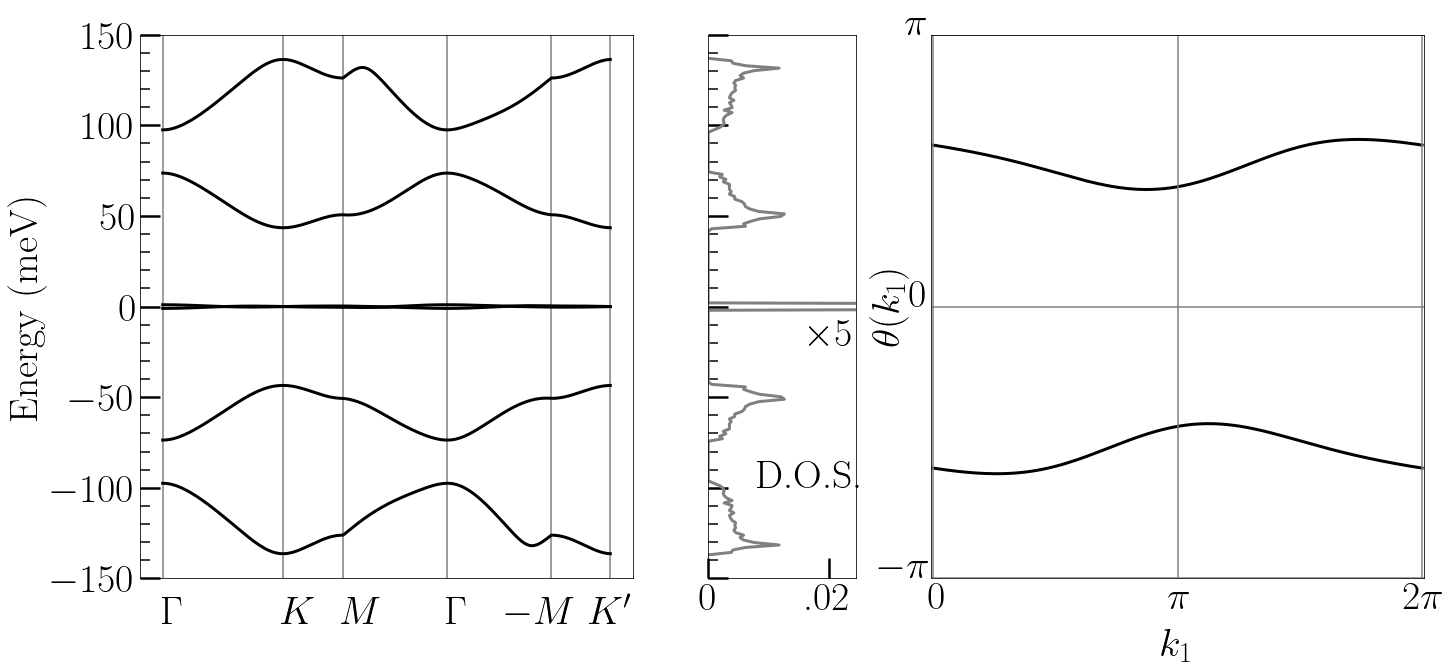

In [19]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 10), gridspec_kw={'width_ratios': [1,0.3,1]})
plt.subplots_adjust(wspace=0.2)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=180)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0],color='gray')
axes[0].text(len_k[0]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[50],color='gray')
axes[0].text(len_k[50]-.15,-175,r'$K$',rotation=0)
axes[0].axvline(x=len_k[100],color='gray')
axes[0].text(len_k[100]-.15,-175,r'$M$',rotation=0)
axes[0].axvline(x=len_k[150],color='gray')
axes[0].text(len_k[150]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[200],color='gray')
axes[0].text(len_k[200]-2.4,-175,r'$-M$',rotation=0)
axes[0].axvline(x=len_k[249],color='gray')
axes[0].text(len_k[249]-1.15,-175,r"$K'$",rotation=0)
axes[0].set_ylim([-150, 150])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

axes[0].set_ylabel(r'Energy (meV)')
for i in range(158,164):
    axes[0].plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')
    
    
ap = np.concatenate(([0],a,[0]))/area
qp = np.concatenate(([b[0]-np.diff(b)[0]/2.0],q,[b[-1]+np.diff(b)[0]/2.0]))

axes[0].get_yaxis().set_major_locator(MultipleLocator(50))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(10))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].get_yaxis().set_ticklabels([])
axes[1].get_yaxis().set_major_locator(MultipleLocator(50))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(10))


axes[1].plot(ap, qp, linewidth=3, color='gray')
axes[1].tick_params(which='major',direction="in",width=2.5, length=20)
axes[1].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].set_xlim([0, 4500/184136])
axes[1].set_ylim([-150, 150])

axes[0].tick_params(direction="in",width=2.5, length=20)
axes[1].text(0.0165,-20,r"$\times 5$",rotation=0)
axes[1].text(0.008,-100,r"D.O.S.",rotation=0)
axes[1].xaxis.set_major_formatter(major_formatter)

axes[2].tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
axes[2].tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

values0=np.mod(np.real(arrayOfEigvalsWilson[:,0]) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)
values1=np.mod(np.real(arrayOfEigvalsWilson[:,1]) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)

v0 = np.zeros(151)
v1 = np.zeros(151)

for i in range(151):
    v0[i] = max(values0[i],values1[i])
    v1[i] = min(values0[i],values1[i])


#plt.plot(range(50), values0,c='black',linewidth=4) 
#plt.plot(range(50), values0,c='black',linewidth=4) 

axes[2].plot(range(151), v0,c='black',linewidth=3) 
axes[2].plot(range(151), v1,c='black',linewidth=3) 

axes[2].axhline(y=0,color='gray')
axes[2].axhline(y=np.pi,color='gray')
axes[2].axhline(y=2*np.pi,color='gray')

axes[2].text(-16.75,0,r'$-\pi$',rotation=0)
axes[2].text(-7.5,np.pi,r'$0$',rotation=0)
axes[2].text(-8.5,2*np.pi,r'$\pi$',rotation=0)

axes[2].axvline(x=0,color='gray')
axes[2].axvline(x=75,color='gray')
axes[2].axvline(x=150,color='gray')

axes[2].text(0-1.5,-0.35,r'$0$',rotation=0)
axes[2].text(75-3,-0.35,r'$\pi$',rotation=0)
axes[2].text(150-6,-0.35,r'$2\pi$',rotation=0)
axes[2].set_xlim([-0.5,150.5])
axes[2].set_ylim([0,2*np.pi])

axes[2].set_ylabel(r'$\theta(k_1)$',labelpad=22)
axes[2].set_xlabel(r'$k_1$',labelpad=50)
#ax = axes[3].subplot(111)
#ax.set_frame_on(False)
axes[2].tick_params(left=False)
plt.savefig('Phase_A.png',bbox_inches='tight')

Now for the B phase

In [20]:
w0 = 0.05/np.sqrt(3)
w1 = 0.8/np.sqrt(3)
vFkth = 110.0*np.sqrt(3)

In [21]:
# now the T-matrices, but the k-dependence is factored out
t1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t3_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):            
        coe = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            
        t2_matrix[m][n] += coe*w0*formFactors1[abs(m),abs(n)]
        t3_matrix[m][n] += coe*w0*formFactors2[abs(m),abs(n)]
            
        if abs(n) > 0 and abs(m) > 0:
            t2_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors1[abs(m)-1,abs(n)-1]
            t3_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors2[abs(m)-1,abs(n)-1]

        if abs(n) > 0:
            t2_matrix[m][n] += np.sign(n)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors1[abs(m),abs(n)-1]
            t3_matrix[m][n] += np.sign(n)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors2[abs(m),abs(n)-1]

        if abs(m) > 0:
            t2_matrix[m][n] += np.sign(m)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors1[abs(m)-1,abs(n)]
            t3_matrix[m][n] += np.sign(m)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors2[abs(m)-1,abs(n)]

        if abs(m) == abs(n):
            t1_matrix[m][n] += w0*coe
            if abs(m) != 0:
                t1_matrix[m][n] += w0*coe*np.sign(m*n)
                    
        if abs(m)-1 == abs(n) and abs(m) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(m)
                
        if abs(n)-1 == abs(m) and abs(n) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(n)

def generateHam(k):
    k1 = np.dot(a1,k)
    k2 = np.dot(a2,k)
    t_mat = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
    t_mat = t1_matrix + np.exp(-1.0j*k2) * t2_matrix + np.exp(1.0j*k1) *t3_matrix
    hamiltonian = np.block([[kinetic_1, t_mat], [t_mat.conj().T, kinetic_2]])
    return(vFkth*hamiltonian)

In [22]:
listOfEigenvals = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

In [23]:
expm_mat = sp.linalg.expm(1.0j*2*np.pi/150.0*z1_total_mat) # dk_2 = 2*pi/150

def getWilsonSpectrum(path):
    for j1, k_vec in enumerate(path):

        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues        
        u_matrix = eigenvecs[:,160:162] # flat bands for wilson loop
        if j1 == 0:
            w_last = u_matrix
            w_first = u_matrix.conj().T         
            
        else:
            w_last = np.dot(u_matrix, np.dot(u_matrix.conj().T, np.dot(expm_mat ,w_last)))
        
    return(np.dot(w_first,np.dot(expm_mat,w_last)))

In [24]:
path_k1 = [[2*np.pi*b1*(j)/150.0+(2*np.pi*b2)*i/150.0 for i in range(150)] for j in range(151)] # path to integrate Wilson loop

listOfEigvalsWilson = []

for path in path_k1:
    wilsonMatrix = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    #listOfEigvalsWilson.append(wilsonMatrix)
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
np.save('Phase_B_Wilson.npy', arrayOfEigvalsWilson)

In [25]:
totalEigs = []
for i in range(50):
    for j in range(50):
        k_vec = 2*np.pi*b1*j/50.0+2*np.pi*b2*i/50.0
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
        totalEigs.append(eigenvals[158:164])   

In [26]:
np.save('Phase_B_histogram.npy',np.array(totalEigs))

In [28]:
total = np.array(totalEigs).flatten()
a, b = np.histogram(total, bins=200)
q = b[:200] + np.diff(b)/2.0
area = sum(a) * np.diff(b)[3]
peak = max(a) * np.diff(b)[3]

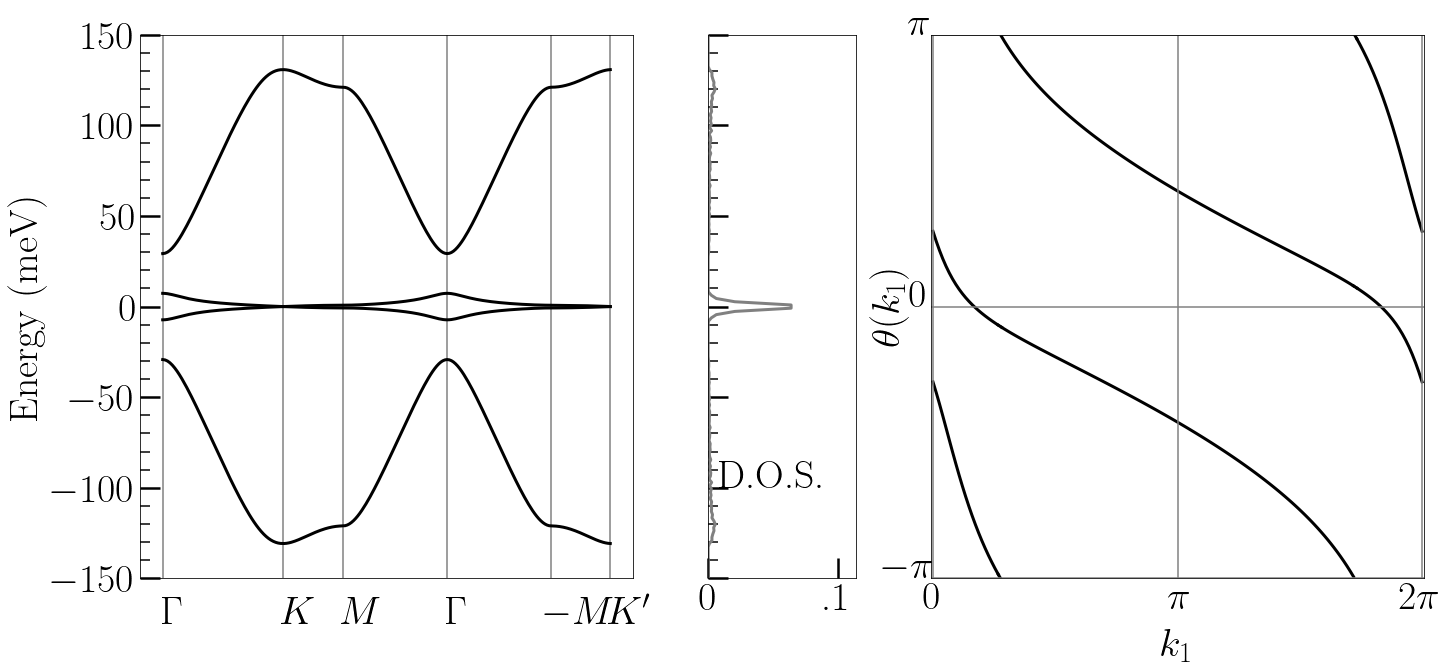

In [29]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 10), gridspec_kw={'width_ratios': [1,0.3,1]})
plt.subplots_adjust(wspace=0.2)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=180)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0],color='gray')
axes[0].text(len_k[0]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[50],color='gray')
axes[0].text(len_k[50]-.15,-175,r'$K$',rotation=0)
axes[0].axvline(x=len_k[100],color='gray')
axes[0].text(len_k[100]-.15,-175,r'$M$',rotation=0)
axes[0].axvline(x=len_k[150],color='gray')
axes[0].text(len_k[150]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[200],color='gray')
axes[0].text(len_k[200]-.4,-175,r'$-M$',rotation=0)
axes[0].axvline(x=len_k[249],color='gray')
axes[0].text(len_k[249]-.15,-175,r"$K'$",rotation=0)
axes[0].set_ylim([-150, 150])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

axes[0].set_ylabel(r'Energy (meV)')
for i in range(158,164):
    axes[0].plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')
    
    
ap = np.concatenate(([0],a,[0]))/area
qp = np.concatenate(([b[0]-np.diff(b)[0]/2.0],q,[b[-1]+np.diff(b)[0]/2.0]))

axes[0].get_yaxis().set_major_locator(MultipleLocator(50))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(10))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].get_yaxis().set_ticklabels([])
axes[1].get_yaxis().set_major_locator(MultipleLocator(50))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(10))


axes[1].plot(ap, qp, linewidth=3, color='gray')
axes[1].tick_params(which='major',direction="in",width=2.5, length=20)
axes[1].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].set_xlim([0, peak/area])
axes[1].set_ylim([-150, 150])

axes[0].tick_params(direction="in",width=2.5, length=20)
#axes[1].text(0.0165,-20,r"$\times 5$",rotation=0)
axes[1].text(0.008,-100,r"D.O.S.",rotation=0)
axes[1].xaxis.set_major_formatter(major_formatter)

axes[2].tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
axes[2].tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

values0=np.mod(np.real(arrayOfEigvalsWilson[:,0]) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)
values1=np.mod(np.real(arrayOfEigvalsWilson[:,1]) - np.array([np.pi*(j/75.0) for j in range(151)])+np.pi,2*np.pi)

v0 = np.zeros(151)
v1 = np.zeros(151)

for i in range(151):
    v0[i] = max(values0[i],values1[i])
    v1[i] = min(values0[i],values1[i])


#plt.plot(range(50), values0,c='black',linewidth=4) 
#plt.plot(range(50), values0,c='black',linewidth=4) 

axes[2].plot(range(151)[0:21], v0[0:21],c='black',linewidth=3) 
axes[2].plot(range(151)[0:21], v1[0:21],c='black',linewidth=3) 

axes[2].plot(range(151)[20:22], [v0[20],v1[21]],c='black',linewidth=3) 
axes[2].plot(range(151)[20:22], [v1[20],v0[21]-2*np.pi],c='black',linewidth=3) 

axes[2].plot(range(151)[21:130], v0[21:130],c='black',linewidth=3) 
axes[2].plot(range(151)[21:130], v1[21:130],c='black',linewidth=3) 

axes[2].plot(range(151)[129:131], [v0[129],v1[130]],c='black',linewidth=3) 
axes[2].plot(range(151)[129:131], [v1[129]+2*np.pi,v0[130]],c='black',linewidth=3) 

axes[2].plot(range(151)[130:151], v0[130:151],c='black',linewidth=3) 
axes[2].plot(range(151)[130:151], v1[130:151],c='black',linewidth=3) 


axes[2].axhline(y=0,color='gray')
axes[2].axhline(y=np.pi,color='gray')
axes[2].axhline(y=2*np.pi,color='gray')

axes[2].text(-15.75,0,r'$-\pi$',rotation=0)
axes[2].text(-7.5,np.pi,r'$0$',rotation=0)
axes[2].text(-7.75,2*np.pi,r'$\pi$',rotation=0)

axes[2].axvline(x=0,color='gray')
axes[2].axvline(x=75,color='gray')
axes[2].axvline(x=150,color='gray')

axes[2].text(0-3,-0.35,r'$0$',rotation=0)
axes[2].text(75-3,-0.35,r'$\pi$',rotation=0)
axes[2].text(150-7,-0.35,r'$2\pi$',rotation=0)
axes[2].set_xlim([-0.5,150.5])
axes[2].set_ylim([0.0,2*np.pi])

axes[2].set_ylabel(r'$\theta(k_1)$',labelpad=22)
axes[2].set_xlabel(r'$k_1$',labelpad=50)
#ax = axes[3].subplot(111)
#ax.set_frame_on(False)
axes[2].tick_params(left=False)
plt.savefig('Phase_B.png',bbox_inches='tight')

Phase C

In [30]:
w0 = 0.7/np.sqrt(3)
w1 = 0.15/np.sqrt(3)
vFkth = 110.0*np.sqrt(3)

In [31]:
# now the T-matrices, but the k-dependence is factored out
t1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t3_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):            
        coe = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            
        t2_matrix[m][n] += coe*w0*formFactors1[abs(m),abs(n)]
        t3_matrix[m][n] += coe*w0*formFactors2[abs(m),abs(n)]
            
        if abs(n) > 0 and abs(m) > 0:
            t2_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors1[abs(m)-1,abs(n)-1]
            t3_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors2[abs(m)-1,abs(n)-1]

        if abs(n) > 0:
            t2_matrix[m][n] += np.sign(n)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors1[abs(m),abs(n)-1]
            t3_matrix[m][n] += np.sign(n)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors2[abs(m),abs(n)-1]

        if abs(m) > 0:
            t2_matrix[m][n] += np.sign(m)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors1[abs(m)-1,abs(n)]
            t3_matrix[m][n] += np.sign(m)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors2[abs(m)-1,abs(n)]

        if abs(m) == abs(n):
            t1_matrix[m][n] += w0*coe
            if abs(m) != 0:
                t1_matrix[m][n] += w0*coe*np.sign(m*n)
                    
        if abs(m)-1 == abs(n) and abs(m) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(m)
                
        if abs(n)-1 == abs(m) and abs(n) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(n)

def generateHam(k):
    k1 = np.dot(a1,k)
    k2 = np.dot(a2,k)
    t_mat = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
    t_mat = t1_matrix + np.exp(-1.0j*k2) * t2_matrix + np.exp(1.0j*k1) *t3_matrix
    hamiltonian = np.block([[kinetic_1, t_mat], [t_mat.conj().T, kinetic_2]])
    return(vFkth*hamiltonian)

In [32]:
listOfEigenvals = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

In [33]:
expm_mat = sp.linalg.expm(1.0j*2*np.pi/150.0*z1_total_mat) # dk_2 = 2*pi/150

def getWilsonSpectrum(path):
    for j1, k_vec in enumerate(path):

        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues        
        u_matrix = eigenvecs[:,160:162] # flat bands for wilson loop
        if j1 == 0:
            w_last = u_matrix
            w_first = u_matrix.conj().T         
            
        else:
            w_last = np.dot(u_matrix, np.dot(u_matrix.conj().T, np.dot(expm_mat ,w_last)))
        
    return(np.dot(w_first,np.dot(expm_mat,w_last)))

In [ ]:
path_k1 = [[2*np.pi*b1*(j)/150.0+(2*np.pi*b2)*i/150.0 for i in range(150)] for j in range(151)] # path to integrate Wilson loop

listOfEigvalsWilson = []

for path in path_k1:
    wilsonMatrix = getWilsonSpectrum(path)
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    #listOfEigvalsWilson.append(wilsonMatrix)
    listOfEigvalsWilson.append(-1.0j*np.log(eigval))
    
arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
np.save('Phase_C_Wilson.npy', arrayOfEigvalsWilson)

In [ ]:
totalEigs = []
for i in range(50):
    for j in range(50):
        k_vec = 2*np.pi*b1*j/50.0+2*np.pi*b2*i/50.0
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
        totalEigs.append(eigenvals[158:164])   

In [ ]:
np.save('Phase_C_histogram.npy',np.array(totalEigs))

In [ ]:
total = np.array(totalEigs).flatten()
a, b = np.histogram(total, bins=200)
q = b[:200] + np.diff(b)/2.0
area = sum(a) * np.diff(b)[3]
peak = max(a) * np.diff(b)[3]

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 40}

matplotlib.rc('font', **font)
matplotlib.rc('text',usetex=True)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(23, 10), gridspec_kw={'width_ratios': [1,0.3,1]})
plt.subplots_adjust(wspace=0.2)

axes[0].get_xaxis().set_visible(False)
axes[0].tick_params(direction="in",width=2.5, length=180)

arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy
axes[0].axvline(x=len_k[0],color='gray')
axes[0].text(len_k[0]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[50],color='gray')
axes[0].text(len_k[50]-.15,-175,r'$K$',rotation=0)
axes[0].axvline(x=len_k[100],color='gray')
axes[0].text(len_k[100]-.15,-175,r'$M$',rotation=0)
axes[0].axvline(x=len_k[150],color='gray')
axes[0].text(len_k[150]-.05,-175,r'$\Gamma$',rotation=0)
axes[0].axvline(x=len_k[200],color='gray')
axes[0].text(len_k[200]-.4,-175,r'$-M$',rotation=0)
axes[0].axvline(x=len_k[249],color='gray')
axes[0].text(len_k[249]-.15,-175,r"$K'$",rotation=0)
axes[0].set_ylim([-150, 150])

#axes[0].xlim([-0.075,len_k[249]+.075])
#plt.ylim([0,2*np.pi])

axes[0].set_ylabel(r'Energy (meV)')
for i in range(158,164):
    axes[0].plot(len_k, arrayOfEigenvals[:,i],linewidth=3,color='black')
    
    
ap = np.concatenate(([0],a,[0]))/area
qp = np.concatenate(([b[0]-np.diff(b)[0]/2.0],q,[b[-1]+np.diff(b)[0]/2.0]))

axes[0].get_yaxis().set_major_locator(MultipleLocator(50))
axes[0].get_yaxis().set_minor_locator(MultipleLocator(10))
axes[0].tick_params(which='major',direction="in",width=2.5, length=20)
axes[0].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].get_yaxis().set_ticklabels([])
axes[1].get_yaxis().set_major_locator(MultipleLocator(50))
axes[1].get_yaxis().set_minor_locator(MultipleLocator(10))


axes[1].plot(ap, qp, linewidth=3, color='gray')
axes[1].tick_params(which='major',direction="in",width=2.5, length=20)
axes[1].tick_params(which='minor',direction="in",width=1.5, length=10)

axes[1].set_xlim([0, peak/area])
axes[1].set_ylim([-150, 150])

axes[0].tick_params(direction="in",width=2.5, length=20)
#axes[1].text(0.0165,-20,r"$\times 5$",rotation=0)
axes[1].text(0.008,-100,r"D.O.S.",rotation=0)
axes[1].xaxis.set_major_formatter(major_formatter)

axes[2].tick_params(axis = 'x', which = "both", bottom = None, top = None,labelbottom=False)
axes[2].tick_params(axis = 'y', which = "both", bottom = None, top = None,labelleft=False)

values0=np.mod(-np.real(arrayOfEigvalsWilson[:,0]) - np.array([np.pi*(j/75.0) for j in range(150)])+np.pi,2*np.pi)
values1=np.mod(-np.real(arrayOfEigvalsWilson[:,1]) - np.array([np.pi*(j/75.0) for j in range(150)])+np.pi,2*np.pi)

v0 = np.zeros(150)
v1 = np.zeros(150)

for i in range(150):
    v0[i] = max(values0[i],values1[i])
    v1[i] = min(values0[i],values1[i])


#plt.plot(range(50), values0,c='black',linewidth=4) 
#plt.plot(range(50), values0,c='black',linewidth=4) 

axes[2].plot(range(150), v0,c='black',linewidth=3) 
axes[2].plot(range(150), v1,c='black',linewidth=3) 


axes[2].axhline(y=0,color='gray')
axes[2].axhline(y=np.pi,color='gray')
axes[2].axhline(y=2*np.pi,color='gray')

axes[2].text(-16.75,0,r'$-\pi$',rotation=0)
axes[2].text(-5.5,np.pi,r'$0$',rotation=0)
axes[2].text(-6.75,2*np.pi,r'$\pi$',rotation=0)

axes[2].axvline(x=0,color='gray')
axes[2].axvline(x=75,color='gray')
axes[2].axvline(x=150,color='gray')

axes[2].text(0-1,-0.35,r'$0$',rotation=0)
axes[2].text(75-1,-0.35,r'$\pi$',rotation=0)
axes[2].text(150-3,-0.35,r'$2\pi$',rotation=0)
axes[2].set_xlim([-0.5,150.5])
axes[2].set_ylim([0,2*np.pi])

axes[2].set_ylabel(r'$\theta(k_1)$',labelpad=22)
axes[2].set_xlabel(r'$k_1$',labelpad=50)
#ax = axes[3].subplot(111)
#ax.set_frame_on(False)
axes[2].tick_params(left=False)
plt.savefig('Phase_C.png',bbox_inches='tight')